##Цель проекта



Разработка системы оценки состояния овощных культур на основе модели нейронной сети с использованием данных квадрокоптера DJI Matrice30t.

##1 Этап разработки: подготовка датасета

Для подготовки датасета используются  видеозаписи квадракоптера DJI Matrice30 полученное в результате пролёта над полигоном агропромышленного комплекса. При помощи библиотек python видео разбивается на кадры с промежутком в 5 секунд для получения уникальных кадров.

In [ ]:
from IPython.display import IFrame

# Ссылка на видео
video_url = "https://drive.google.com/file/d/1HsPxOrnLD4K155OFFvOn2LSROPtlei8x/preview"

# Отображаем видео через IFrame
IFrame(video_url, width="640", height="480")

In [ ]:
import requests
import cv2
import os

# Скачиваем видео с Google Диска
video_url = "https://drive.google.com/file/d/1HsPxOrnLD4K155OFFvOn2LSROPtlei8x/preview"
video_id = video_url.split("/")[-2]
download_url = f"https://drive.google.com/uc?export=download&id={video_id}"
response = requests.get(download_url, stream=True)

# Создаем папку "Frames", если она не существует
if not os.path.exists("Frames"):
    os.makedirs("Frames")

frame_count = 0

# Открываем видео с помощью OpenCV
with open(f"video_{video_id}.mp4", "wb") as f:
    for chunk in response.iter_content(chunk_size=8192):
        f.write(chunk)

cap = cv2.VideoCapture(f"video_{video_id}.mp4")

# Разложение видео на кадры и сохранение в папку "Frames"
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    frame_count += 1
    frame_filename = f"Frames/frame_{frame_count:04d}.jpg"

    # Сохраняем текущий кадр
    cv2.imwrite(frame_filename, frame)

cap.release()
cv2.destroyAllWindows()

print(f"Количество сохраненных кадров: {frame_count}")

Количество сохраненных кадров: 300


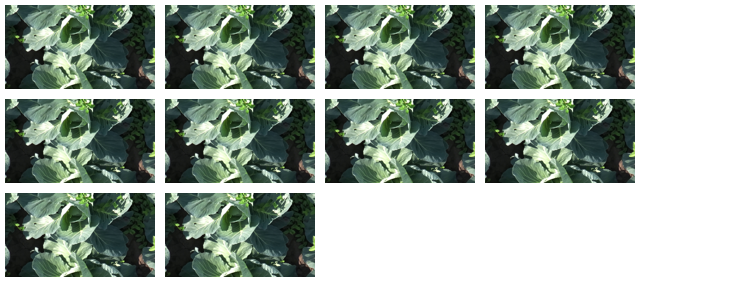

In [ ]:
from IPython.display import display
import glob
from PIL import Image, ImageOps, ImageDraw

# Получаем список файлов с кадрами
frame_files = sorted(glob.glob("Frames/*.jpg"))

# Вывод миниатюрных изображений
thumbnails = []
for i in range(10):
    img = Image.open(frame_files[i])
    img.thumbnail((150, 150))
    thumbnails.append(img)

# Создаем монтаж изображений для вывода
montage_width = 750
montage_height = 300
montage = Image.new(mode='RGB', size=(montage_width, montage_height), color="white")

x_offset = 0
y_offset = 0

for thumbnail in thumbnails:
    thumbnail_with_border = ImageOps.expand(thumbnail, border=5, fill="white")
    montage.paste(thumbnail_with_border, (x_offset, y_offset))
    x_offset += thumbnail_with_border.width
    if x_offset + thumbnail_with_border.width > montage_width:
        x_offset = 0
        y_offset += thumbnail_with_border.height

display(montage)

#вывод на печать 10 первых кадров:

In [ ]:
from google.colab import files
files.download("/content/Frames")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

##Этап 2: Размножение датасета

Далее разрабатывается программа для аугментации (искусственного размножения) датасета.
Ноутбук с аугментацией:https://colab.research.google.com/drive/1xlKT9v9a3NN7QgdDN1J409DXad0xBKy-?usp=sharing#scrollTo=IuX-iG_JzTU7

Аугментация датасета делается для увеличения количества данных, которые используются для обучения модели машинного обучения. Это может помочь улучшить точность и общую производительность модели, так как имеется ограниченное количество исходных данных

Далее используется сервис cvat.ai размечаются изображениях повреждённые кочаны капусты на которых Нейронная сеть будет обучаться : https://www.cvat.ai

На выходе разметки bbox на изображении в cvat мы получаем координаты прямоугольной рамки, ограничивающей объект на изображении. Эти координаты мы будем использовать для для обучения модели машинного обучения для распознавания и классификации на изображениях кочанов капусты.

##Этап 3:Подготовка и обучение Нейронной сети

Модель YOLO (You Only Look Once) является одной из наиболее эффективных моделей для распознавания объектов на изображениях. При распознавании зараженных кочанов капусты, модель YOLO может быть более эффективной, чем другие модели, потому что она способна обнаруживать мелкие дефекты и изменения на поверхности капусты, которые могут быть не заметны на первый взгляд.

## Подготовка YOLOv8

##Импорт и установка необходимых библиотек библиотек

In [ ]:
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.8/644.8 kB 6.3 MB/s eta 0:00:00


Загружаем предобученную моедль

In [ ]:
from ultralytics import YOLO

# Load a model
model = YOLO("yolov8n.pt")  # load a pretrained model

100%|██████████| 6.23M/6.23M [00:00<00:00, 83.7MB/s]


Дальнешим шагом мы обучаем нашу модель на нашем размеченном датасете.

In [ ]:
# Train the model
results = model.train(data="/content/drive/MyDrive/data_cab/data.yaml", imgsz=800, batch=8, epochs=100, plots=True)

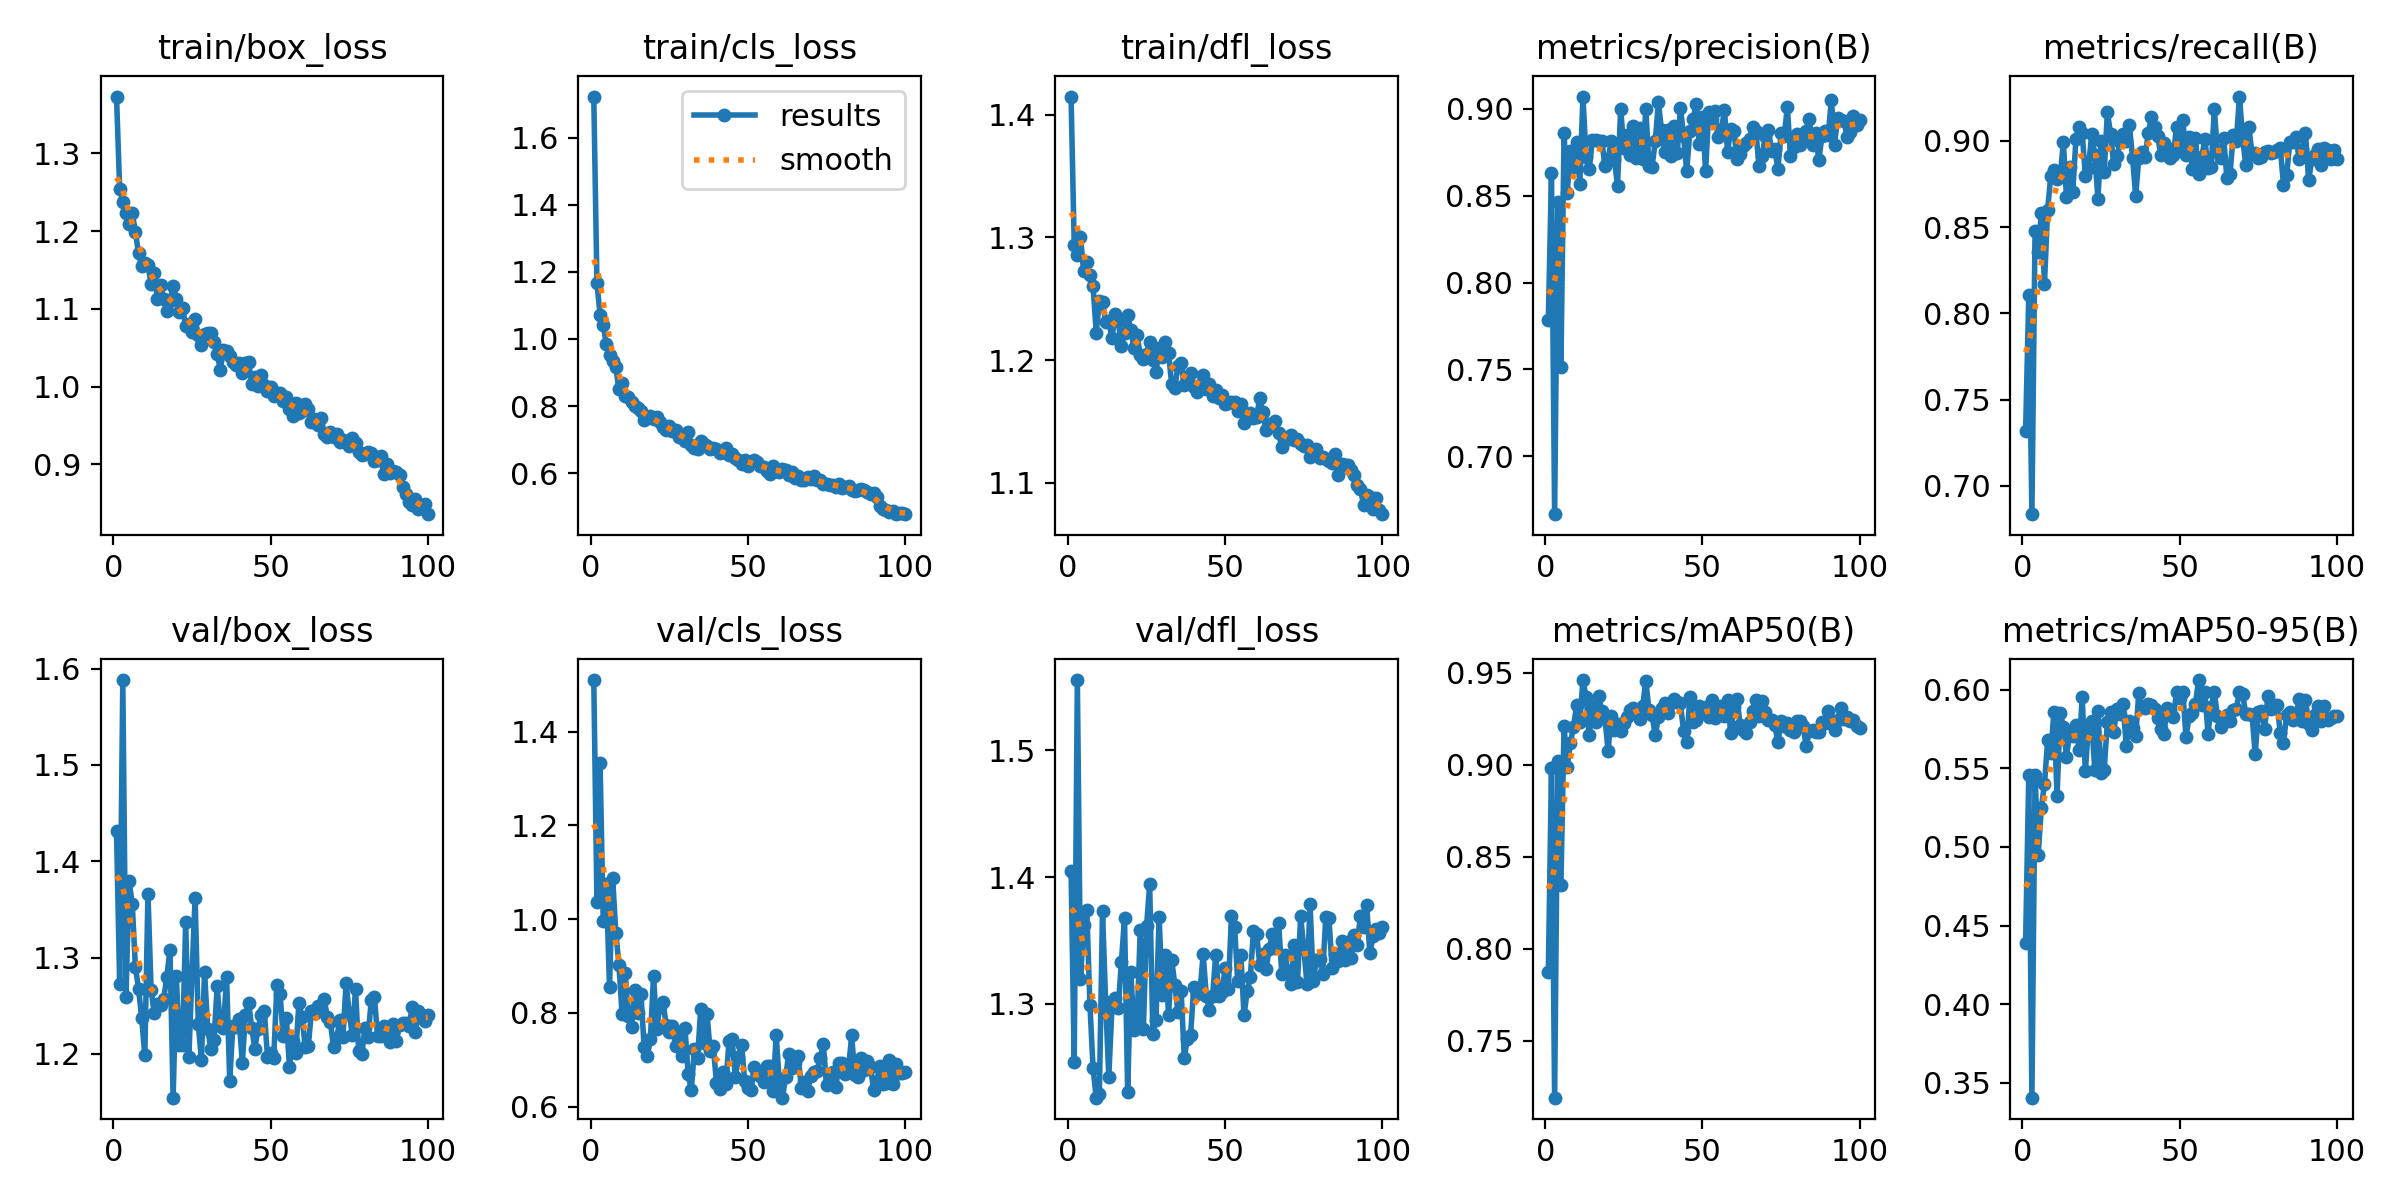

In [ ]:
# Импортируем библиотеку для отображения графика с результатами обучения
from IPython.display import Image
Image(filename='/content/runs/detect/train/results.png', height=600)

In [ ]:
# Сохраним лучшие веса, постоянно не переобучать модель

from google.colab import drive
drive.mount('/content/drive')

import shutil

# Путь к исходному файлу
source_path = '/content/runs/detect/train/weights/best.pt'

# Путь к целевой папке на Google Диске
target_path = '/content/drive/MyDrive/data_cab/weights/'

# Копирование файла на Google Диск
shutil.copy(source_path, target_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


'/content/drive/MyDrive/data_cab/weights/best.pt'

In [ ]:
# Загружаем веса
model = YOLO("/content/drive/MyDrive/data_cab/weights/best.pt")

In [ ]:
 # Если модель уверена на 50% в наличии кочана, то она его покажет (conf = 0.5)
 model.val(conf=0.5)
 # or you can set the data you want to val
 model.val(data="/content/drive/MyDrive/data_cab/data.yaml", conf=0.5)

Ultralytics YOLOv8.0.203 🚀 Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3005843 parameters, 0 gradients, 8.1 GFLOPs
100%|██████████| 755k/755k [00:00<00:00, 27.8MB/s]
val: Scanning /content/drive/MyDrive/data_cab/valid/labels.cache... 73 images, 1 backgrounds, 0 corrupt: 100%|██████████| 73/73 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:24<00:00,  4.85s/it]
                   all         73       1130      0.946      0.726      0.837      0.581
Speed: 1.9ms preprocess, 6.0ms inference, 0.0ms loss, 2.0ms postprocess per image
Results saved to runs/detect/val
Ultralytics YOLOv8.0.203 🚀 Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (Tesla T4, 15102MiB)
val: Scanning /content/drive/MyDrive/data_cab/valid/labels.cache... 73 images, 1 backgrounds, 0 corrupt: 100%|██████████| 73/73 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P         

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7fc44a05b820>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

##Этап 4 Применение обученной модели на кадрах

Данный код открывает видеофайл и проходит по каждому кадру в видео. Для каждого кадра происходит инференс (обнаружение объектов) с использованием модели YOLOv8. Результаты инференса наносятся на кадр в виде визуальных аннотаций. Аннотированный кадр отображается в окне. Если пользователь нажимает клавишу 'q', то цикл останавливается и программа завершается. Если достигнут конец видеофайла, то цикл также прекращается.

In [ ]:
from google.colab.patches import cv2_imshow
import cv2


# Open the video file
video_path = "/content/drive/MyDrive/data_cab/video_test/cab_cut.mp4"
cap = cv2.VideoCapture(video_path)

# Loop through the video frames
while cap.isOpened():
    # Read a frame from the video
    success, frame = cap.read()

    if success:
        # Run YOLOv8 inference on the frame
        results = model(frame)

        # Visualize the results on the frame
        annotated_frame = results[0].plot()

        # Display the annotated frame
        cv2_imshow(annotated_frame)

        # Break the loop if 'q' is pressed
        if cv2.waitKey(1) & 0xFF == ord("q"):
            break
    else:
        # Break the loop if the end of the video is reached
        break

# Release the video capture object and close the display window
cap.release()
cv2.destroyAllWindows()

Так же мы можем применить модель на видео. Для этого методом model.predict мы применяем нашу модель на видео. Для сохранения итогового результата, меняем параметр save на True

In [ ]:
model.predict(source = "/content/drive/MyDrive/data_cab/video_test/cab_cut.mp4", save = True, conf=0.4, show = False)



WARNING ⚠️ inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

video 1/1 (1/450) /content/drive/MyDrive/data_cab/video_test/cab_cut.mp4: 480x800 2 bads, 86.6ms
video 1/1 (2/450) /content/drive/MyDrive/data_cab/video_test/cab_cut.mp4: 480x800 2 bads, 8.7ms
video 1/1 (3/450) /content/drive/MyDrive/data_cab/video_test/cab_cut.mp4: 480x800 3 bads, 9.2ms
video 1/1 (4/450) /content/drive/MyDrive/data_cab/video_test/cab_cut.mp4: 480x800 2 bads, 9.3ms
video 1/1 (5/450) /content/drive/MyDrive/data_cab/video_test/cab_cut.mp

[ultralytics.engine.results.Results object with attributes:
 
 boxes: ultralytics.engine.results.Boxes object
 keypoints: None
 masks: None
 names: {0: 'bad'}
 orig_img: array([[[138, 174, 157],
         [141, 177, 160],
         [145, 181, 164],
         ...,
         [ 17,  51,  39],
         [  9,  43,  31],
         [ 10,  44,  32]],
 
        [[ 98, 134, 117],
         [108, 144, 127],
         [112, 148, 131],
         ...,
         [ 16,  50,  38],
         [ 11,  45,  33],
         [ 12,  46,  34]],
 
        [[ 84, 117, 101],
         [ 84, 117, 101],
         [ 84, 117, 101],
         ...,
         [ 12,  46,  34],
         [ 17,  51,  39],
         [ 19,  53,  41]],
 
        ...,
 
        [[  9,  57,  50],
         [  9,  57,  50],
         [ 13,  61,  54],
         ...,
         [ 27,  83,  72],
         [ 32,  88,  77],
         [ 34,  90,  79]],
 
        [[ 50,  98,  91],
         [ 50,  98,  91],
         [ 53, 101,  94],
         ...,
         [ 31,  85,  72],
      

In [ ]:
from moviepy.editor import *

input_video = "/content/runs/detect/predict/cab_cut.avi"
output_video = "cab_cut.mp4"

clip = VideoFileClip(input_video)
clip.write_videofile(output_video)

Moviepy - Building video cab_cut.mp4.
Moviepy - Writing video cab_cut.mp4



t: 100%|█████████▉| 450/451 [01:38<00:00,  4.51it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file /content/runs/detect/predict/cab_cut.avi, 6220800 bytes wanted but 0 bytes read,at frame 450/451, at time 15.52/15.52 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



Moviepy - Done !
Moviepy - video ready cab_cut.mp4


In [ ]:
from IPython.display import HTML
from base64 import b64encode
mp4 = open('video.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)